## 加入修正项之后进行涨跌预测可以保证稳赚不赔
- 需要预测的信号是一个产品的涨跌 (X_n = +-1)，以此决定做多做空.  
- 假定我们手头有一个预测模型 (Z_n), 它有一定的正确率 (正确率由$u_n$决定, $Z_n = X_n * u_n$), 其中$u_n$是一个取值在{-1, 1}上的随机变量.   
- 引入修正项$S_n,\ $定义$Y_n = Z_n * S_n$. 其中$S_n$为一个Bernoulli随机变量，取值在{1, -1}中. 
- $P(S_n = 1) = confidence_n,\ $其中$confidence_n = 1\ \textbf{if}\ q_n > 0.5,\ \textbf{else}\ p_n. $这里$p_n$和$q_n$分别是修正模型和未修正模型的历史正确率.   
- 通过数值试验，我们初步发现: 
  1. 在模型准确度较好(正确率 > 0.5)时，修正后的模型可以保证正确率不降低(稳赚)
  2. 在模型准确度较差时(正确率 < 0.5)时，修正后的模型可以保证正确率维持在0.5(不赔)

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
burn_in = 1000
total_iterations = 100000

# 真实信号
# X_n = +1 涨，-1 跌
# 生成方式为Bernoulli r.v. 0.3 的概率涨，0.7 的概率跌
X_n = np.random.choice([-1, 1], p = [0.3, 0.7], size=total_iterations)

# 假定我们有一个预测方法Z_n, 它预测X_n有一定的概率正确，这个概率服从一个正态分布
def simulate(mean_up):
    std_up = 0.3
    # Z_n正确的概率定义为u_n, u_n服从正态分布，只取0-1之间的值
    u_n = np.random.normal(mean_up, std_up, size=total_iterations)
    u_n[u_n < 0] = 0
    u_n[u_n > 1] = 1

    Z_n = X_n * np.where(np.random.rand(total_iterations) < u_n, 1, -1)
    # Z_n = X_n * np.random.choice([-1, 1], p = [0.7, 0.3], size=total_iterations)

    # q_n是Z_n预测正确的概率
    # p_n是Y_n预测正确的概率, Y_n是Z_n和S_n的乘积, S_n是我们的修正项
    q_n_values = np.zeros(total_iterations)
    p_n_values = np.zeros(total_iterations)
    p1_n_values = np.zeros(total_iterations)
    p2_n_values = np.zeros(total_iterations)

    # Arrays for S_n and Y_n
    S_n = np.zeros(total_iterations)
    S_1n = np.zeros(total_iterations)
    S_2n = np.zeros(total_iterations)
    Y_n = np.zeros(total_iterations)
    Y_1n = np.zeros(total_iterations)
    Y_2n = np.zeros(total_iterations)
    match_count = 0
    q_match = 0
    match1_count = 0
    match2_count = 0
    # Simulation
    for i in range(total_iterations):
        if i == 0:
            p_n = 0.5  # Initial probability p_0
            q_n = 0.5
            p1_n = 0.5
            p2_n = 0.5
        else:
            p_n = match_count / i 
            p1_n = match1_count / i
            p2_n = match2_count / i
            q_n = q_match / i
        
        p_n_values[i] = p_n
        q_n_values[i] = q_n
        p1_n_values[i] = p1_n
        p2_n_values[i] = p2_n
        
        # Determine S_n based on p_n
        # S_n[i] = np.random.choice([-1, 1], p=[1 - np.exp(p_n)/np.exp(1), np.exp(p_n) / np.exp(1)])
        # confidence = 1 if q_n > 0.5 else p_n
        # confidence = 1 if q_n > 0.5 else 1 - 2 * q_n
        confidence = 1 if q_n > 0.5 else 1 - 2 * q_n
        confidence_1 = 1 if q_n > 0.5 else p1_n
        confidence_2 = 1 if q_n > 0.5 else q_n

        S_n[i] = np.random.choice([-1, 1], p=[1 - confidence, confidence])
        S_1n[i] = np.random.choice([-1, 1], p=[1 - confidence_1, confidence_1])
        S_2n[i] = np.random.choice([-1, 1], p=[1 - confidence_2, confidence_2])
        # S_n[i] = np.random.choice([-1, 1], p=[1 - p_n, p_n])
        # S_n[i] = np.random.choice([-1, 1], p=[1 - q_n, q_n])
        # S_n[i] = np.random.choice([-1, 1], p=[1 - np.exp(q_n)/np.exp(1), np.exp(q_n) / np.exp(1)])
        # Compute Y_n
        Y_n[i] = Z_n[i] * S_n[i]
        Y_1n[i] = Z_n[i] * S_1n[i]
        Y_2n[i] = Z_n[i] * S_2n[i]
        
        # Update match_count
        if Y_n[i] == X_n[i]:
            match_count += 1
        if Y_1n[i] == X_n[i]:
            match1_count += 1
        if Y_2n[i] == X_n[i]:  
            match2_count += 1
        if Z_n[i] == X_n[i]:
            q_match += 1
        # Plotting p_n after burn-in
    plt.figure(figsize=(12, 6))
    plt.plot(range(burn_in, total_iterations), p_n_values[burn_in:], label='p_n')
    plt.plot(range(burn_in, total_iterations), q_n_values[burn_in:], label='no adjustment')
    plt.plot(range(burn_in, total_iterations), p1_n_values[burn_in:], label='p1_n')
    plt.plot(range(burn_in, total_iterations), p2_n_values[burn_in:], label='p2_n')
    plt.axvline(x=burn_in, color='r', linestyle='--', label='Burn-in threshold')
    plt.xlabel('Iterations (n)')
    plt.ylabel('Probability')
    plt.title('Variation of winning rate with n')
    plt.legend()
    plt.grid(True)
    plt.show()
    return p_n_values.mean(), p1_n_values.mean(), p2_n_values.mean(), q_n_values.mean()
# print(u_n.mean())
# print(p_n_values.mean())
# print(q_n_values.mean())




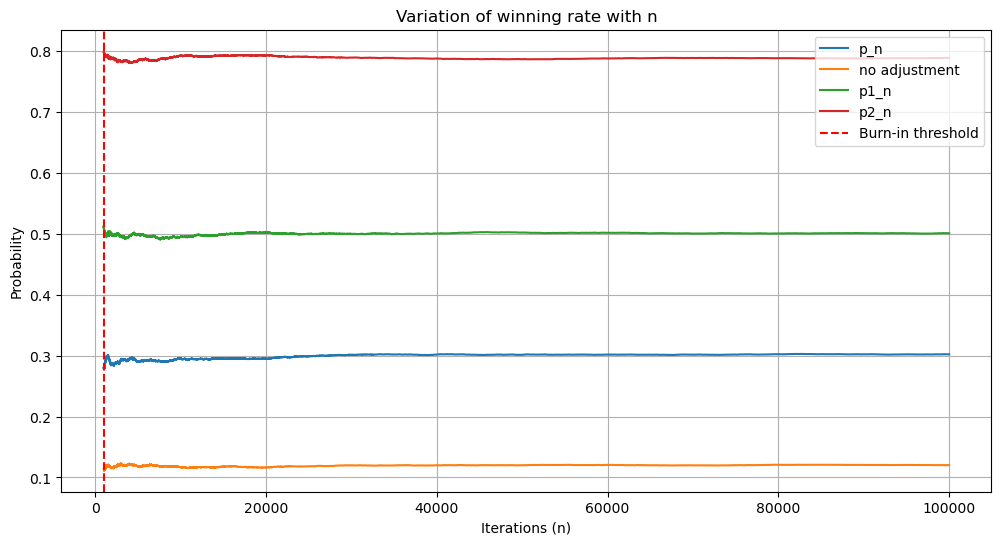

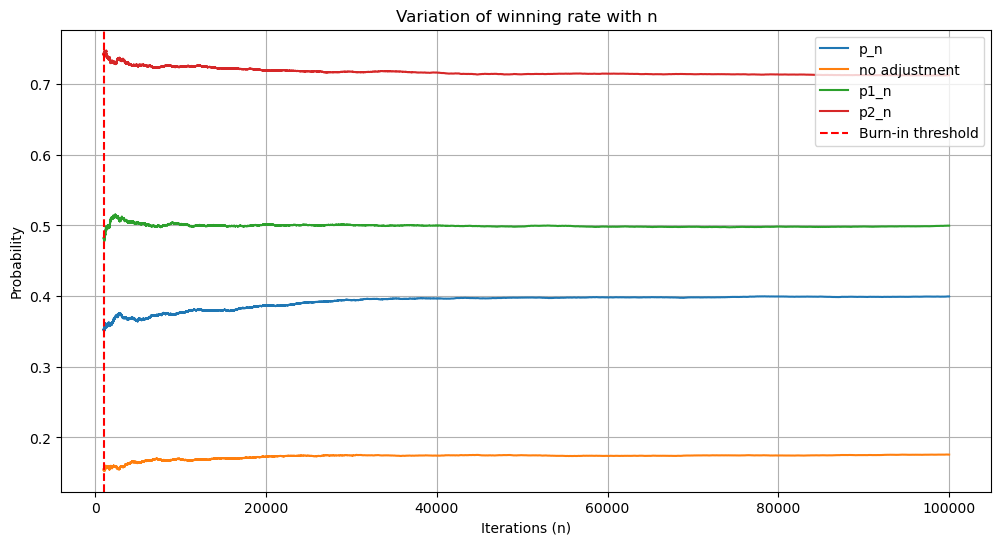

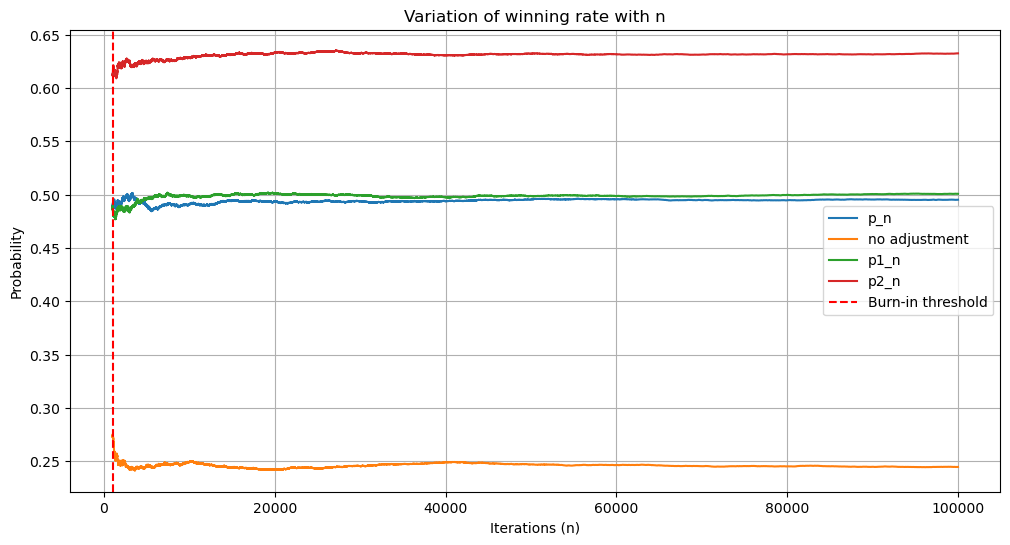

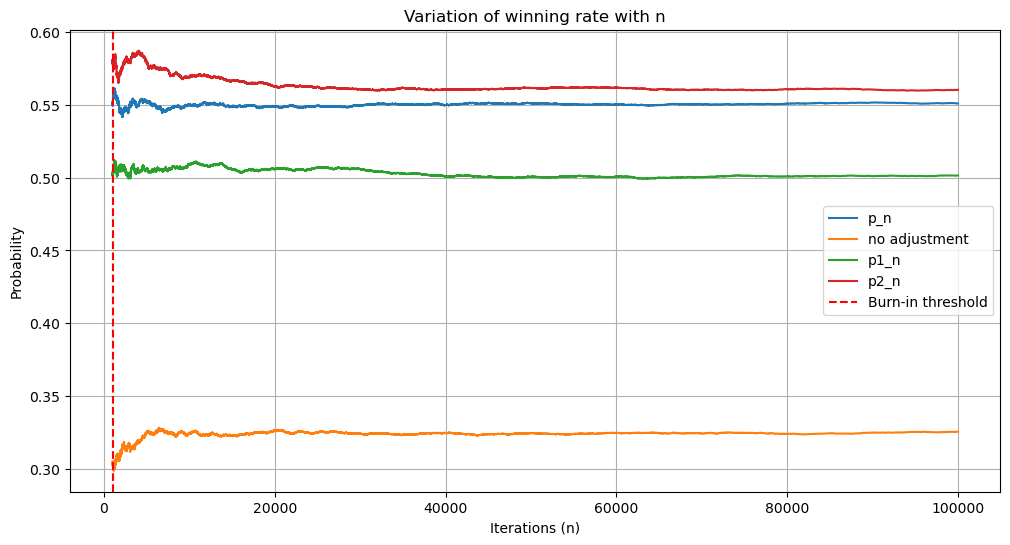

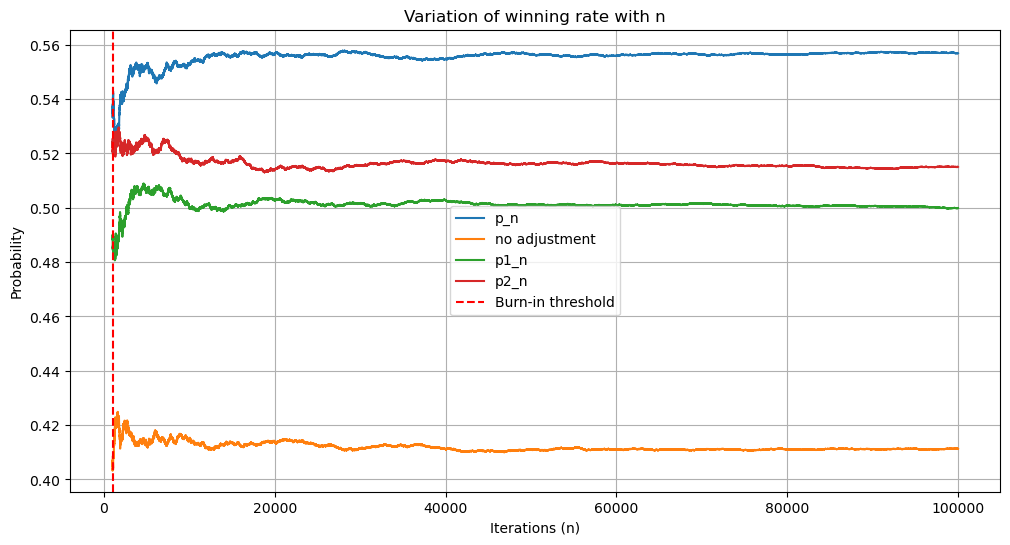

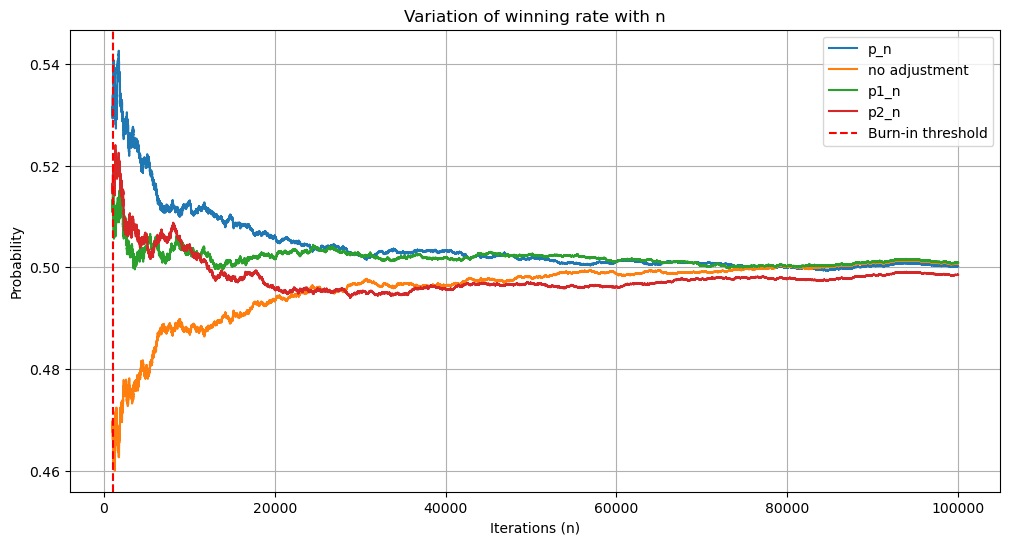

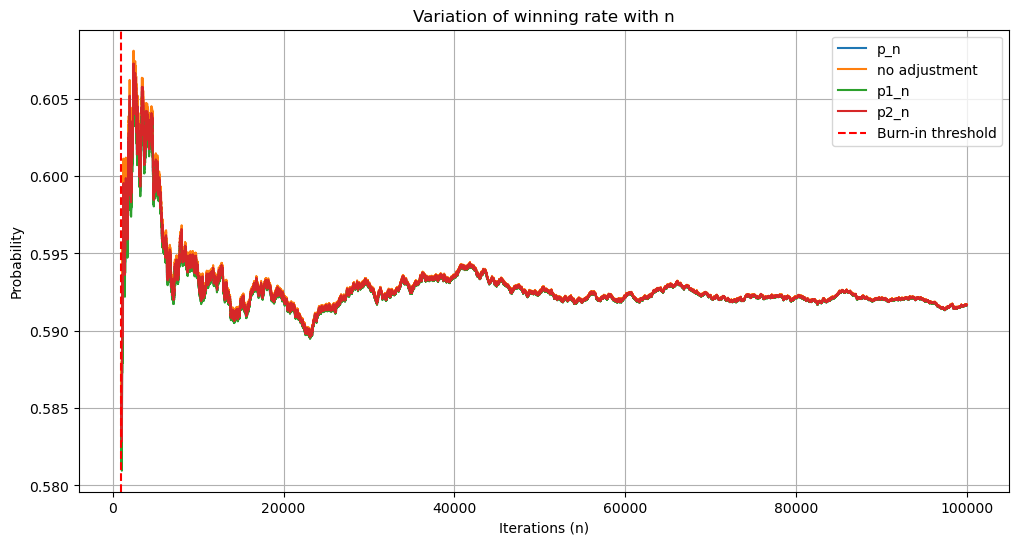

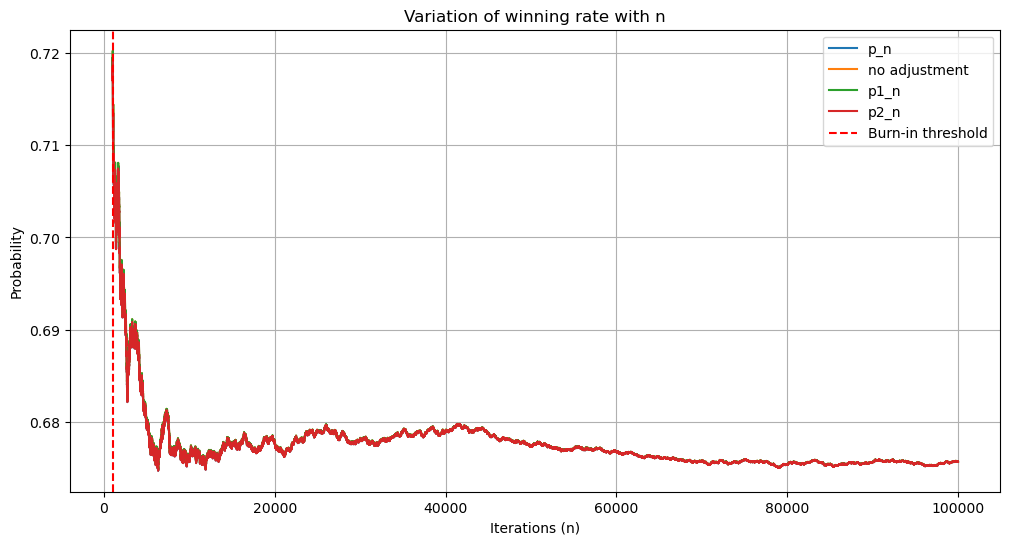

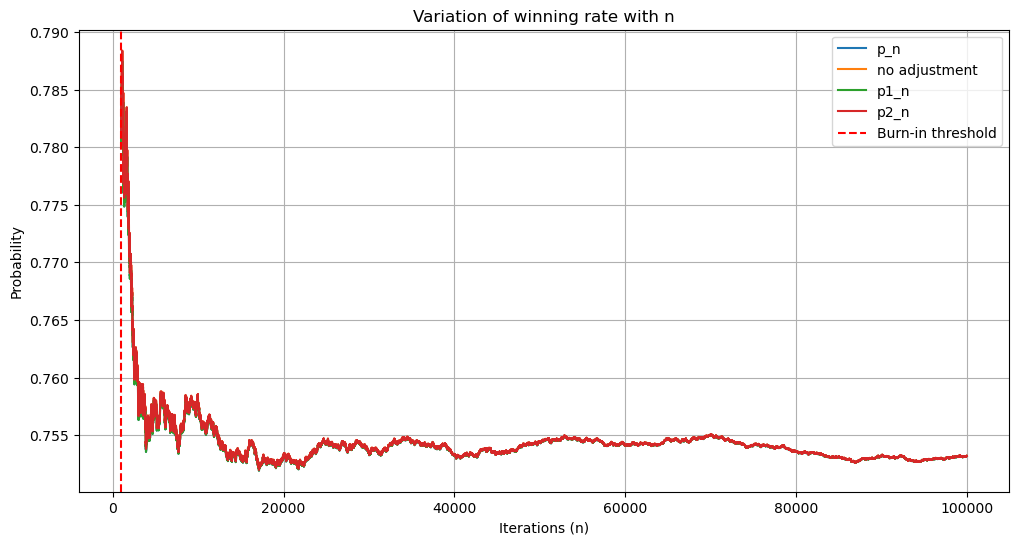

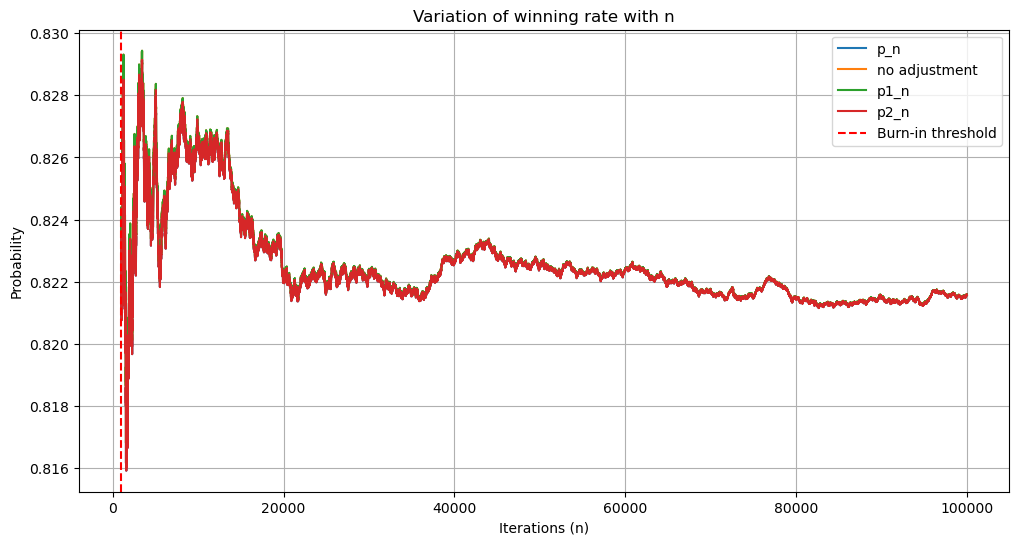

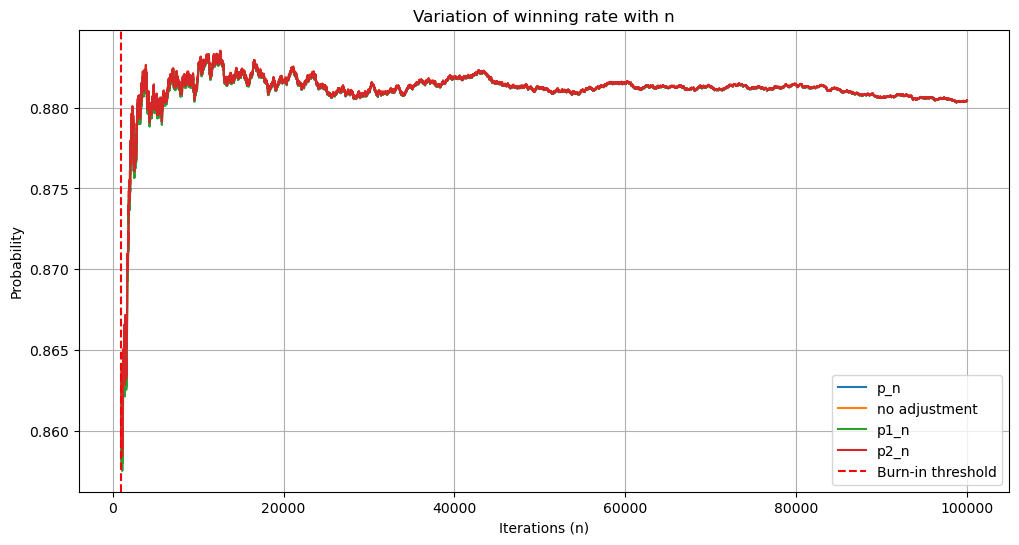

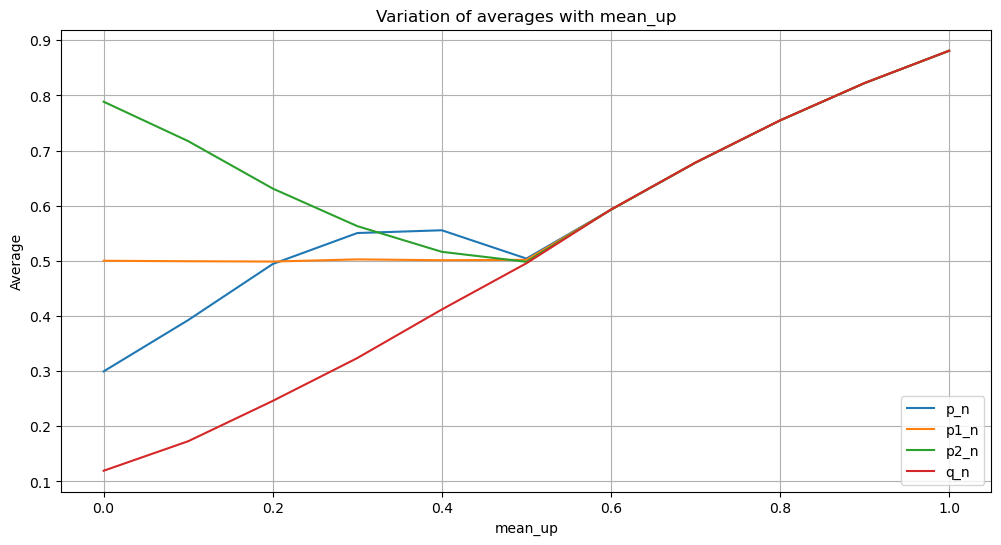

In [38]:
mean_up_values = np.arange(0, 1.05, 0.1)
p_n_averages = []
p1_n_averages = []
p2_n_averages = []
q_n_averages = []

for mean_up in mean_up_values:
    p_n_avg, p1_n_avg, p2_n_avg, q_n_avg = simulate(mean_up)
    p_n_averages.append(p_n_avg)
    p1_n_averages.append(p1_n_avg)
    p2_n_averages.append(p2_n_avg)
    q_n_averages.append(q_n_avg)

plt.figure(figsize=(12, 6))
plt.plot(mean_up_values, p_n_averages, label='p_n')
plt.plot(mean_up_values, p1_n_averages, label='p1_n')
plt.plot(mean_up_values, p2_n_averages, label='p2_n')
plt.plot(mean_up_values, q_n_averages, label='q_n')
plt.xlabel('mean_up')
plt.ylabel('Average')
plt.title('Variation of averages with mean_up')
plt.legend()
plt.grid(True)
plt.show()